**3. Widefield Post-CPA Individual Batch Processing** 

Written by Jessica Kline

This code is the third step in analyzing widefield blinking videos and assumes that "1. Find QDs" and "2. Gaussian CPA Fittings" have already been run on all of the necessary data. It reads in the all of the ".csv" containing parameters assoicated with the CPA fit of one folder worth of data. Crunches the numbers and compiles the following statistics outputing them as both text files and images

Statistics
*   Distribution of CPA Levels
*   Expected OFF Event Dwell Time Distribution
*   Expected ON Event Dwell Time Distribution
*   Weighted ON/OFF Ratio Distribution
*   % time ON distribtuion
*   % time OFF distribution
*   Distribution of CPA assigned intensity levels
*   Distribution of Camera measured intensities for all QDs
*   QD Dying test
*   Time to First Dark Event
*   Random frame intensity distribution for all QDs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
import os
from os import listdir
from os.path import isfile, join
import random
import logging

Mounted at /content/drive


In [ ]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.major.pad']='10'
plt.rcParams['ytick.major.pad']='4'

logging.getLogger('matplotlib.font_manager').disabled = True

In [ ]:
#@title tick_settings
def tick_settings(x_minor = 1, y_minor = 1):
  plt.gca().xaxis.set_minor_locator(MultipleLocator(x_minor))
  plt.gca().yaxis.set_minor_locator(MultipleLocator(y_minor))
  plt.gca().tick_params(which='minor', bottom=True, top=True, left=True, right=True)
  plt.gca().tick_params(bottom=True, top=True, left=True, right=True)
  plt.tick_params(axis = 'both', direction = 'in', length = 6, width = 1.5)
  plt.gca().tick_params(which='minor', direction = "in", length = 4, width = 0.75)

This code expects the following file tree:
1. parent_folder = directory_path/Large Data Folder/analyzed_data/ (where large data folder is for example all videos collected on May 12th and analyzed_data is the folder created by the particle picking)
2. data_location = directory_path/Large Data Folder/analyzed_data/CPA_params/ (save folder for the CPA parameters from the blinking traces extracted from all videos collected on May 12th)

In [ ]:
parent_folder = "//InsertYourPathHere/analyzed_data//"    ## change for selecting the directory
data_location = parent_folder + "CPA_params/"
intensity_location = parent_folder + "particle_picking/traces/"
data_name = "All ROI Params.csv"      
save_location = parent_folder

bin_size_ms = 50        #time bins size in ms
total_frames = 8000     #total frames in the videos

In [ ]:
#combines all ROI outputs from CPA fitting in one batch into one file or reads that file if it already exists
if os.path.exists(data_location + data_name) == False:
  onlyfiles = [f for f in listdir(data_location) if isfile(join(data_location, f))]

  total_I_list = []

  for f in onlyfiles:
    temp_Ilist = pd.read_csv(data_location+f)
    temp_Ilist = temp_Ilist.to_numpy()
    temp_Ilist = np.delete(temp_Ilist, 0, axis = 1)
    temp_Ilist = temp_Ilist.reshape(1,-1)
    temp_Ilist = temp_Ilist[0].tolist()
    for i in temp_Ilist:
      total_I_list.append(i)
  
  total_I_list = np.array(total_I_list)
  params = total_I_list.reshape(-1,6)
  pd.DataFrame(params).to_csv(os.path.join(data_location,data_name))
else:
  params = pd.read_csv(data_location+data_name)
  params = params.to_numpy()
  params = np.delete(params, 0, axis = 1)

In [ ]:
#@title create lists for plotting

loc_nan = np.argwhere(np.isnan(params[:,0]))
number_of_states = []
on_time = []
off_time = []
on_off_ratio = []
time_spent = []
time_to_dark = []
CPA_I_list = []
highest_int_state = []
highest_int_state_x = []
start_ = 0
discarded = 0
non_blinking = 0

for n in range(len(loc_nan)):
  finish_ = loc_nan[n][0]
  #block
  temp_arr = params[start_:finish_]
  temp_arr = temp_arr[temp_arr[:,0].argsort()]  #lowestI is 0 to highestI at n      # I, sigma, %, alpha, <t>

  #create list of identified intensity states
  for j in temp_arr:
    for k in range(int(j[2]*2000)):
      CPA_I_list.append(j[0])
  
  if len(temp_arr) < 6:
    number_of_states.append(len(temp_arr))      #number of CPA states

    if temp_arr[0,5] != 999999:
      time_to_dark.append(temp_arr[0,5])        # time to first dark event if a dark event occurs

    if len(temp_arr) > 2:   #for more than two states
      #block
      on_time.append(temp_arr[-1,4])          #on time expected dwell time
      divider = 0
      calc_on = 0

      #weighted off time calculation
      for r in range(0,len(temp_arr)-1):
        calc_off += temp_arr[r,4]*temp_arr[r,3]  
        divider += temp_arr[r,3]
      on_time.append(calc_off/divider)      #weighted off time expected dwell time

      on_off_ratio.append(calc_off/(temp_arr[-1,4]*temp_arr[-1,3]))   #weighted on/off ratio
      time_spent.append(1-temp_arr[-1, 2])                            #time spent off
      #block
    else:
      if len(temp_arr) == 2:  #for 2 level
        on_time.append(temp_arr[1,4])   #on time expected dwell time
        off_time.append(temp_arr[0,4])  #off time expected dwell time
        on_off_ratio.append((temp_arr[1,4]*temp_arr[1,3])/(temp_arr[0,4]*temp_arr[0,3]))  #weighted on/off ratio
        time_spent.append(temp_arr[0,2])  #time spent off
      else:     #for 1-level
        time_spent.append(0)
        on_time.append(np.nan)
        off_time.append(np.nan)
        on_off_ratio.append(np.nan)
  else:
    discarded += 1
  #block
  start_ = finish_+1
#end for

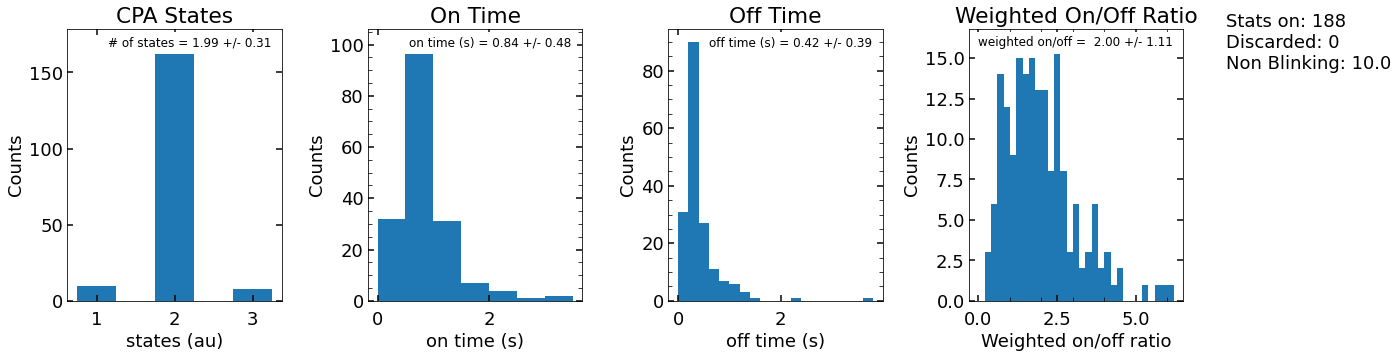

In [ ]:
#@title BLINKING STATS FIG
ff = plt.figure()
ff.set_figwidth(20)
ff.set_figheight(5)

#CPA Level Distribution
plt.subplot(1,4,1, xlabel = "states (au)", ylabel = "Counts", title = "CPA States")
plt.tick_params(axis = 'both', direction = 'in', length = 6, width = 1.5)
tick_settings(x_minor = 1, y_minor = 100)
hh_ = plt.hist(number_of_states, bins = np.arange(np.amin(number_of_states) - 0.25, np.amax(number_of_states)+0.75, 0.5))
t = plt.text(0.95, 0.95, "# of states = " + str("{:.2f}".format(np.mean(number_of_states))) + " +/- " + str("{:.2f}".format(np.std(number_of_states))), fontsize = 12, horizontalalignment='right',
verticalalignment='center', transform=plt.gca().transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

#Expected ON Time
plt.subplot(1,4,2, xlabel = "on time (s)", ylabel = "Counts", title = "On Time")
plt.hist(on_time, bins = np.arange(0, np.nanmax(on_time)+0.5, 0.5))
tick_settings(x_minor = 5, y_minor = 5)
t = plt.text(0.95, 0.95, "on time (s) = " + str("{:.2f}".format(np.nanmean(on_time))) + " +/- " + str("{:.2f}".format(np.nanstd(on_time))), fontsize = 12, horizontalalignment='right',
verticalalignment='center', transform=plt.gca().transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

#Expected OFF Time
plt.subplot(1,4,3,xlabel = "off time (s)", ylabel = "Counts", title = "Off Time")
plt.hist(off_time, bins = np.arange(0, np.nanmax(off_time)+0.2, 0.2))
tick_settings(x_minor = 5, y_minor = 5)
t = plt.text(0.95, 0.95, "off time (s) = " + str("{:.2f}".format(np.nanmean(off_time))) + " +/- " + str("{:.2f}".format(np.nanstd(off_time))), fontsize = 12, horizontalalignment='right',
verticalalignment='center', transform=plt.gca().transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


#Weighted ON/OFF Ratio
plt.subplot(1,4,4, xlabel = "Weighted on/off ratio", ylabel = "Counts", title = "Weighted On/Off Ratio")
plt.hist(on_off_ratio, bins = np.arange(0, np.nanmax(on_off_ratio)+0.2, 0.2))
tick_settings(x_minor = 1, y_minor = 5)
t = plt.text(0.95, 0.95, "weighted on/off =  " + str("{:.2f}".format(np.nanmean(on_off_ratio))) + " +/- " + str("{:.2f}".format(np.nanstd(on_off_ratio))), fontsize = 12, horizontalalignment='right',
verticalalignment='center', transform=plt.gca().transAxes)
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


plt.text(1.2, 0.95, "Stats on: " + str(len(number_of_states)) + "\nDiscarded: " + str (discarded) + "\nNon Blinking: " + str(hh_[0][0]) , horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)

plt.subplots_adjust(wspace=0.4,hspace=0.4)

all_data = np.array([np.array(number_of_states),np.array(on_time), np.array(off_time), np.array(on_off_ratio)]).T
if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(all_data, columns = ['num states', 'on time(s)', 'off time(s)', 'weighted on/off']).to_csv(os.path.join(save_location,"Statistics.csv"))
plt.savefig(save_location+"Statistics.jpg", bbox_inches = 'tight')

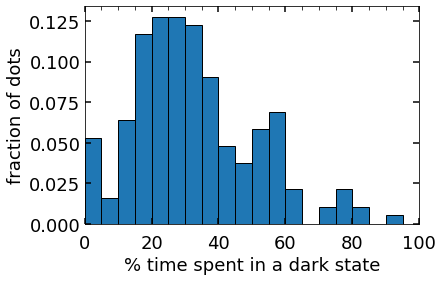

In [ ]:
#@title % TIME OFF
h,bins = np.histogram(time_spent, bins = np.arange(0, 1.1, 0.05))
height = []
for n in range(len(h)):
  height.append(h[n]/len(number_of_states))

plt.bar(bins[:-1]*100, height, width = 5, align = 'edge', edgecolor = 'k')
tick_settings(x_minor = 5, y_minor = 0.05)
plt.xlim([0,100])
plt.xlabel('% time spent in a dark state')
plt.ylabel('fraction of dots')

if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(np.array([bins[:-1], height]).T, columns=['% time', 'frac dots']).to_csv(os.path.join(save_location,"DarkFraction.csv"))
plt.savefig(save_location+"DarkFraction.jpg", bbox_inches = 'tight')

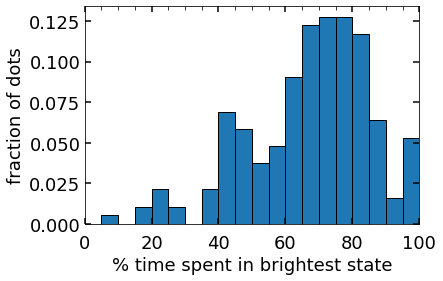

In [ ]:
#@title % TIME ON
height_light = []
for n in range(len(height)-2,-1,-1):
  height_light.append(height[n])

height_light.append(0)

plt.bar(bins[:-1]*100, height_light, width = 5, align = 'edge', edgecolor = 'k')
tick_settings(x_minor = 5, y_minor = 0.05)
plt.xlim([0,100])
plt.xlabel('% time spent in brightest state')
plt.ylabel('fraction of dots')

if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(np.array([bins[:-1], height_light]).T, columns=['% time', 'frac dots']).to_csv(os.path.join(save_location,"LightFraction.csv"))
plt.savefig(save_location+"LightFraction.jpg", bbox_inches = 'tight')

In [ ]:
#@title Avg % ON
on_per = []
for x in time_spent:
  if x != 0:
    on_per.append(1-x)

on_per_arr = np.array([len(on_per), np.mean(on_per), np.std(on_per)])

if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(on_per_arr, columns = ['% on']).to_csv(os.path.join(save_location,"OnPercent.csv"))

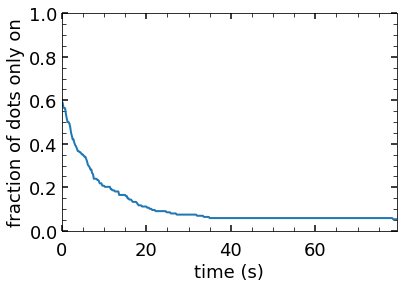

In [ ]:
#@title TIME TO FIRST DARK EVENT
counts, bins = np.histogram(time_to_dark, bins = np.arange(0, 400, 0.2))
total_counts = len(number_of_states)

dropping = [(total_counts - counts[0])/total_counts]
for j in range(1,len(bins)):
  dropping.append((total_counts - np.sum(counts[0:j]))/total_counts)

plt.plot(bins, dropping, linewidth = 2)
plt.ylim([0,1])
plt.xlim([0, np.amax(time_to_dark)+1])
plt.xlabel('time (s)')
plt.ylabel('fraction of dots only on')
tick_settings(x_minor = 5, y_minor = 0.05)

if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(np.array([bins, dropping]).T, columns=['time(s)', 'frac on']).to_csv(os.path.join(save_location,"TimeToDark.csv"))
plt.savefig(save_location+"TimeToDark.jpg", bbox_inches = 'tight')

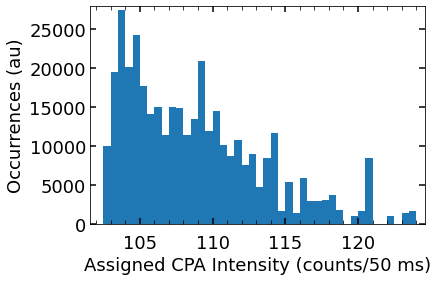

In [ ]:
#@title CPA INTENSITY DISTRIBUTION
h = plt.hist(CPA_I_list, bins = np.arange(0, 300, 0.5))
plt.xlabel(f'Assigned CPA Intensity (counts/{bin_size_ms} ms)')
plt.ylabel('Occurrences (au)')
tick_settings(x_minor = 1, y_minor = 50000)
plt.ylim([0,np.amax(h[0]+500)])
plt.xlim([np.amin(CPA_I_list)-1, np.amin([np.amax(CPA_I_list)+1, 250])])

if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(np.array([h[1][:-1], h[0]]).T, columns=['assigned CPA intensity', 'occurrences']).to_csv(os.path.join(save_location,"CPAIntensityDistribution.csv"))
plt.savefig(save_location+"CPA Intensity Distribtion.jpg", bbox_inches = 'tight')

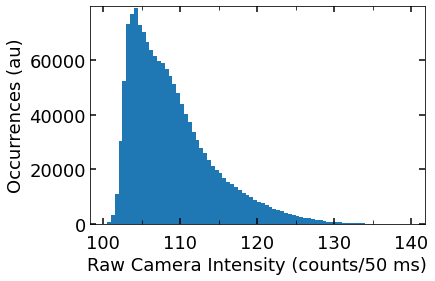

In [ ]:
#@title CAMERA INTENSITY DISTRIBUTION
onlyfiles = [f for f in listdir(intensity_location) if isfile(join(intensity_location, f))]

total_I_list = []
for f in onlyfiles:
  temp_Ilist = pd.read_csv(intensity_location+f)
  temp_Ilist = temp_Ilist.to_numpy()
  temp_Ilist = np.delete(temp_Ilist, 0, axis = 1)
  temp_Ilist = temp_Ilist.reshape(1,-1)
  temp_Ilist = temp_Ilist[0].tolist()
  for i in temp_Ilist:
    total_I_list.append(i)

h = plt.hist(total_I_list, bins = np.arange(0, 300, 0.5))
plt.xlabel(f'Raw Camera Intensity (counts/{bin_size_ms} ms)')
plt.ylabel('Occurrences (au)')
tick_settings(x_minor = 5, y_minor = 100000)
plt.ylim([0,np.amax(h[0]+500)])
plt.xlim([np.amin(total_I_list)-1, np.amin([np.amax(total_I_list)+1, 250])])

if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(np.array([h[1][:-1], h[0]]).T, columns=['raw camera intensity', 'occurrences']).to_csv(os.path.join(save_location,"CameraIntensityDistribution.csv"))
plt.savefig(save_location+"Camera Intensity Distribtion.jpg", bbox_inches = 'tight')

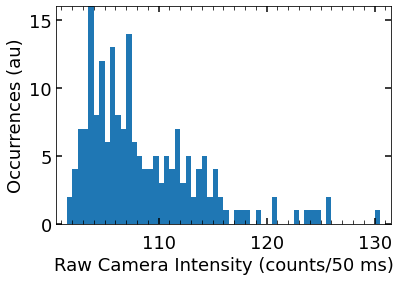

In [ ]:
#@title RANDOM FRAME CAMERA INTENSITY DISTRIBUTION
onlyfiles = [f for f in listdir(intensity_location) if isfile(join(intensity_location, f))]

rand = random.randint(0,2000)

total_I_list = []
for f in onlyfiles:
  temp_Ilist = pd.read_csv(intensity_location+f)
  temp_Ilist = temp_Ilist.to_numpy()
  temp_Ilist = np.delete(temp_Ilist, 0, axis = 1)
  for r in range(len(temp_Ilist[0,:])):
    total_I_list.append(temp_Ilist[rand,r])

h = plt.hist(total_I_list, bins = np.arange(0, np.amax(total_I_list)+0.5, 0.5))
plt.xlabel(f'Raw Camera Intensity (counts/{bin_size_ms} ms)')
plt.ylabel('Occurrences (au)')
tick_settings(x_minor = 1, y_minor = 25)
plt.ylim([0,np.amax(h[0])])
plt.xlim([np.amin(total_I_list)-1, np.amin([np.amax(h[1])+1, 250])])

if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(np.array([h[1][:-1], h[0]]).T, columns=['raw camera intensity', 'occurrences']).to_csv(os.path.join(save_location,"CameraIntensityDistributionRandomFrame.csv"))
plt.savefig(save_location+"Camera Intensity Distribtion Random Frame.jpg", bbox_inches = 'tight')

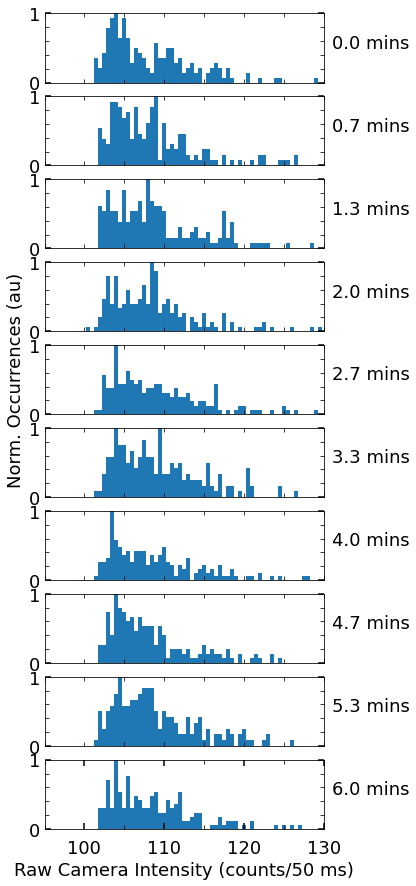

In [ ]:
#@title DYING CHECK
onlyfiles = [f for f in listdir(intensity_location) if isfile(join(intensity_location, f))]

time_check = np.arange(0,total_frames,int(total_frames/10))
cnt = 0
dying_check = []
for t in time_check:
  total_I_list = []
  cnt+=1
  for f in onlyfiles:
    temp_Ilist = pd.read_csv(intensity_location+f)
    temp_Ilist = temp_Ilist.to_numpy()
    temp_Ilist = np.delete(temp_Ilist, 0, axis = 1)
    for r in range(len(temp_Ilist[0,:])):
      total_I_list.append(temp_Ilist[t,r])

  h = np.histogram(total_I_list, bins = np.arange(80, 300, 0.5))
  group_norm = h[0]/np.amax(h[0])
  dying_check = np.append(dying_check,group_norm)

  plt.subplot(10,1, cnt)
  plt.bar(h[1][:-1], group_norm, width = 0.5)
  if cnt == 10:
    plt.xlabel(f'Raw Camera Intensity (counts/{bin_size_ms} ms)')
  else:
    plt.xticks([])
  if cnt == 5:
    plt.ylabel('Norm. Occurrences (au)')
  plt.text(131, 0.5, "{:.1f}".format(t*bin_size_ms/60000)+ ' mins') 
  tick_settings(x_minor = 5, y_minor = 0.2)
  plt.ylim([0,1])
  plt.xlim([95, 130])

dying_check = dying_check.reshape([len(time_check),-1])

ff = plt.gcf()
ff.set_figwidth(5)
ff.set_figheight(15)

if os.path.exists(save_location) == False:
  os.mkdir(save_location)
pd.DataFrame(dying_check.T).to_csv(os.path.join(save_location,"DyingCheck.csv"))
plt.savefig(save_location+"DyingCheck.jpg", bbox_inches = 'tight')